In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [ ]:
!nvidia-smi

In [ ]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [ ]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

### Load data

Link: https://huggingface.co/datasets/samsum

In [ ]:
from datasets import load_dataset, concatenate_datasets,DatasetDict


dataset = load_dataset('ccdv/pubmed-summarization')



dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

split_lengths = [len(dataset[split])for split in dataset]


# Evaluating PEGASUS on SAMSum

In [ ]:
dataset['test'][0]['article']

"anxiety affects quality of life in those living with parkinson 's disease ( pd ) more so than overall cognitive status , motor deficits , apathy , and depression [ 13 ] . \n although anxiety and depression are often related and coexist in pd patients , recent research suggests that anxiety rather than depression is the most prominent and prevalent mood disorder in pd [ 5 , 6 ] . yet , \n our current understanding of anxiety and its impact on cognition in pd , as well as its neural basis and best treatment practices , remains meager and lags far behind that of depression . \n overall , neuropsychiatric symptoms in pd have been shown to be negatively associated with cognitive performance . \n for example , higher depression scores have been correlated with lower scores on the mini - mental state exam ( mmse ) [ 8 , 9 ] as well as tests of memory and executive functions ( e.g. , attention ) [ 1014 ] . \n likewise , apathy and anhedonia in pd patients have been associated with executive d

In [ ]:
len(dataset['test'])

2250

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset['test'][0]['article'] )

print(pipe_out)

In [ ]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'article', column_summary='abstract', batch_size=8)

<ipython-input-36-1b5c8fd83bef>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


100%|██████████| 282/282 [16:59<00:00,  3.61s/it]


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

# Histogram

Token indices sequence length is longer than the specified maximum sequence length for this model (5520 > 1024). Running this sequence through the model will result in indexing errors


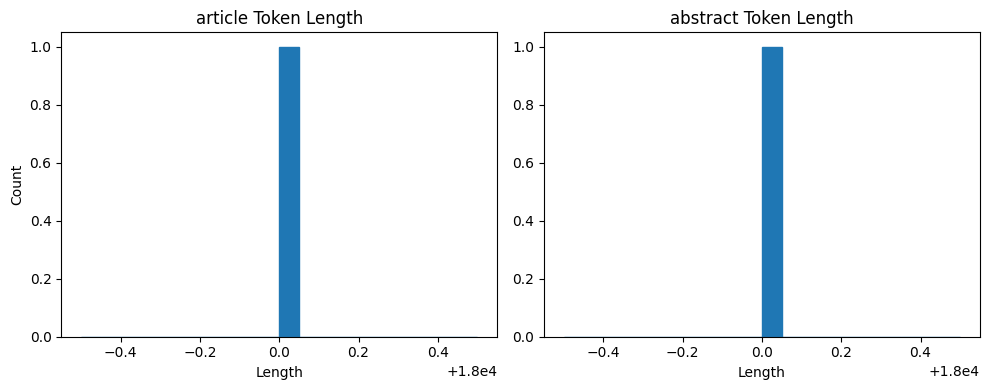

In [ ]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset['train']['article']])

summary_token_len = len([tokenizer.encode(s) for s in dataset['train']['abstract']])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("article Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("abstract Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['article'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['abstract'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_pt = dataset.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/text_summarization

/content/drive/MyDrive/text_summarization


In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-summarization', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [ ]:

trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_pt["train"],
                  eval_dataset=dataset_pt["validation"])

In [ ]:
trainer.train()


In [ ]:
score = calculate_metric_on_test_ds(
    dataset['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'article', column_summary= 'abstract'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

In [ ]:
## Save model
model_pegasus.save_pretrained("pegasus-summarization-model")

In [ ]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Test

In [ ]:
dataset_test = load_dataset("ccdv/pubmed-summarization")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:
import pandas as pd
df = pd.read_csv("/content/Constraint_Train.csv")



#reference = dataset_test["test"][0]["abstract"]

In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("tokenizer")
model = AutoModelForSeq2SeqLM.from_pretrained("pegasus-summarization-model")
i=0
summaries = []
for text in df["tweet"]:
    max_seq_length = model.config.max_position_embeddings
    inputs = tokenizer(text, truncation=True, max_length=max_seq_length, return_tensors="pt")
    summary_ids = model.generate(inputs["input_ids"])
    summary = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens=True)
    summaries.append(summary)
    i=i+1
    print(i)

df["summary"] = summaries

# Save updated CSV file
df.to_csv("/content/output_file.csv", index=False)




print("article:")
#print(sample_text)


print("\nReference Abstract:")
#print(reference)

print("\nSummary generated:")
print(summary)

